# Test application of ML classifier to data

Takes pickled traing sklearn model and applies to data from DEA

Model is trained using data extracted to a CSV file, can be downloaded from: https://rsg.pml.ac.uk/shared_files/dac/train_input_geomedian_tmad_subset.txt.gz

The model is trained using something like the code below:

```python
import pickle
import numpy
from sklearn import tree

# Read in text file
model_input = numpy.loadtxt("train_input_geomedian_tmad_subset.txt", skiprows=1)

# Set up model
model = tree.DecisionTreeClassifier(random_state=0, max_depth=5)

# Train model
classifier = model.fit(model_input[:,1:7], model_input[:,0])

# Pickle model
with open('model_pickle.pickle', 'wb') as f:
    pickle.dump(classifier,f)

```


In [140]:
import os
import pickle
import sys

import datacube
from datacube import helpers
from datacube.utils import geometry
from matplotlib import pyplot
import numpy
import sklearn
import yaml

# Load in modules from repos
sys.path.append('/home/jovyan/development/LCCS/decision_tree')
import dea_classificationtools

sys.path.append('/home/jovyan/development/dea-notebooks/Scripts')
from dea_bandindices import calculate_indices
from dea_plotting import display_map

sys.path.append('/home/jovyan/development/livingearth_lccs')
from le_lccs.le_classification import lccs_l3

In [141]:
# Set up working dir
working_dir = '/home/jovyan/cultivated_classification'

In [142]:
# Load in pickled data
with open(os.path.join(working_dir, 'model_pickle.pickle'), 'rb') as f:
    classifier = pickle.load(f)

# Prediction

In [143]:
# Read in config file with site bounds
with open("au_test_sites.yaml", "r") as f:
    config = yaml.safe_load(f)

In [144]:
# Specify site
site_name = "Leichhardt"

# Get bounds
x = (config[site_name]["min_x"],config[site_name]["max_x"])
y = (config[site_name]["max_y"],config[site_name]["min_y"])

query = {'time': ('2015-01-01', '2015-02-01')}
query['x'] = x
query['y'] = y
query['crs'] = 'EPSG:3577'
query['resolution'] = (-100, 100)

In [145]:
dc = datacube.Datacube(app = 'classifiers')

new_data = dc.load(product='ls8_nbart_geomedian_annual', group_by='solar_day', dask_chunks={'x' : 1000, 'y' : 1000}, **query)

In [146]:
if classifier.n_features_ == 12:
    new_data = calculate_indices(new_data, 'BUI', collection='ga_ls_2')
    new_data = calculate_indices(new_data, 'BSI', collection='ga_ls_2')
    new_data = calculate_indices(new_data, 'NBI', collection='ga_ls_2')
    new_data = calculate_indices(new_data, 'EVI', collection='ga_ls_2')
    new_data = calculate_indices(new_data, 'NDWI', collection='ga_ls_2')
    new_data = calculate_indices(new_data, 'MSAVI', collection='ga_ls_2')

In [147]:
predicted = dea_classificationtools.predict_xr(classifier, new_data, progress=True)

[                                        ] | 0% Completed |  0.0s

/usr/local/lib/python3.6/dist-packages/dask/array/blockwise.py:241: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


[##################################      ] | 85% Completed |  0.5s

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


[##################################      ] | 85% Completed |  2.5s

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.1s


[########################################] | 100% Completed |  5.6s


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.1s finished


## Colour and plot the classified data

In [148]:
red, green, blue, alpha = lccs_l3.colour_lccs_level3(predicted[0])

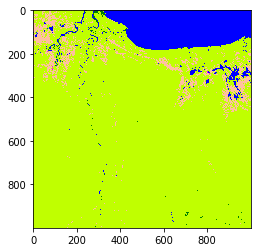

In [149]:
pyplot.imshow(numpy.dstack([red, green, blue, alpha]))

## Save out to GeoTiff

In [150]:
# Get only cultivated layer
cultivated = predicted.where(predicted == 111)

out = cultivated.isel(time=0).transpose()
out = cultivated.to_dataset(name="cultivated")
out.attrs['crs']=geometry.CRS(new_data.crs)
out = out.isel(time=0)

In [151]:
helpers.write_geotiff(os.path.join(working_dir, '{}_cultivated.tif'.format(site_name.lower().replace(' ','_'))), out)